<a href="https://colab.research.google.com/github/caroldaza/DM_CyT/blob/main/smallworldofwords_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/')

In [ ]:
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (8,6)

import numpy as np
import pandas as pd   

!pip install networkx powerlaw community

import networkx as nx
import community
import powerlaw
from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

from sklearn.metrics import adjusted_rand_score

from networkx.algorithms.community import modularity
import community.community_louvain as community_louvain

In [4]:
filename = '/content/drive/MyDrive/SWOW-EN.R100.csv.zip'
datos = pd.read_csv(filename, sep=',')
datos.head()

,Unnamed: 0,id,participantID,age,gender,nativeLanguage,country,education,created_at,cue,R1,R2,R3
0,1,29,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,although,nevertheless,yet,but
1,2,30,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,deal,no,cards,shake
2,3,31,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,music,notes,band,rhythm
3,4,32,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,inform,tell,rat on,NaN
4,5,33,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,way,path,via,method


In [5]:
datos.shape

(1228200, 13)

In [6]:
edad=[30,50]
data_filt1 = datos[datos.age.isin(edad)]
data_filt1.shape

(50145, 13)

In [7]:
data_filt2 = data_filt1[data_filt1['nativeLanguage']=='United States']
data_filt2.shape

(25661, 13)

In [8]:
data_filt3 = data_filt2[data_filt2['country']=='United States']
data_filt3.shape

(23606, 13)

In [9]:
# Nos quedamos solo con la cue y la primera palabra. Tambien botamos Nans
data = data_filt3.loc[:,['cue','R1']]
data = data.dropna(how='any')

# Sacar palabras de una letra
data.drop(data[data['cue'].str.len().lt(2)].index, inplace=True)
data.drop(data[data['R1'].str.len().lt(2)].index, inplace=True)

data.head()

,cue,R1
990,supply,give
991,raise,up
992,no,yes
993,likely,will
994,up,down


In [10]:
data.shape

(23322, 2)

In [11]:
# ¿Cuántas claves y respuestas son únicas?
print(data['cue'].unique().shape)
print(data['R1'].unique().shape)

(10338,)
(8049,)


In [12]:
# ¿cuántas palabras de R1 están en Cue? ¿alrevés?
print(sum(data['R1'].isin(data['cue'].unique())))
print(sum(data['cue'].isin(data['R1'].unique())))

17957
11492


In [13]:
# Sacar palabras que no este en cue Y en R1
data.drop(data[data['R1'].isin(data['cue'].unique())==False].index, inplace=True)
data.drop(data[data['cue'].isin(data['R1'].unique())==False].index, inplace=True)

In [14]:
data.shape[0]

8986

In [15]:
# la frecuencia de cada cue
new_df = data['cue'].str.split(expand=True).stack().value_counts().reset_index()
new_df.columns = ['Word', 'Frequency'] 

In [231]:
new_df.head()

,Word,Frequency
0,up,10
1,loo,9
2,bit,8
3,compensation,8
4,grocery,8


Text(0, 0.5, 'frequency')

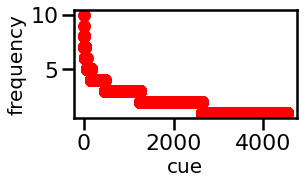

In [16]:
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.plot(new_df['Frequency'],'ro')
plt.xlabel("cue",fontsize=20)
plt.ylabel("frequency",fontsize=20)

Text(0, 0.5, 'frequency')

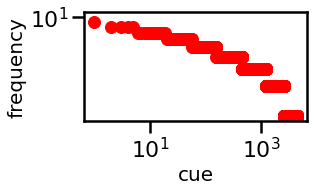

In [17]:
#plt.loglog(np.linspace(1, len(new_df['Frequency']),len(new_df['Frequency'])),new_df['Frequency'].to_numpy())
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.yscale('log')
plt.xscale('log')
plt.plot(new_df['Frequency'],'ro')
plt.xlabel("cue",fontsize=20)
plt.ylabel("frequency",fontsize=20)

In [18]:
# la frecuencia de cada R1
new_df_R1 = data['R1'].str.split(expand=True).stack().value_counts().reset_index()
new_df_R1.columns = ['Word', 'Frequency'] 

Text(0, 0.5, 'frequency')

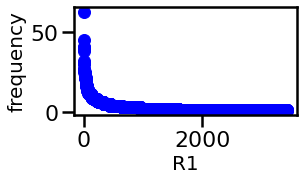

In [19]:
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.plot(new_df_R1['Frequency'],'bo')
plt.xlabel("R1",fontsize=20)
plt.ylabel("frequency",fontsize=20)

Text(0, 0.5, 'frequency')

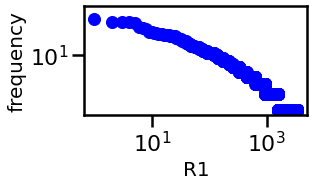

In [20]:
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.yscale('log')
plt.xscale('log')
plt.plot(new_df_R1['Frequency'],'bo')
plt.xlabel("R1",fontsize=20)
plt.ylabel("frequency",fontsize=20)

La matriz de adyacencia:

In [21]:
df_firstrows = pd.crosstab(data.cue, data.R1)
idx = df_firstrows.columns.union(df_firstrows.index)
matriz = df_firstrows.reindex(index = idx, columns=idx, fill_value=0) #armo la matriz de adyacencia

Calculo del grafo

In [23]:
G1= nx.from_pandas_adjacency(matriz)

Histograma de grado pero hecho con el grafo:

In [24]:
print(nx.info(G1))
print('Is weigthed:',nx.is_weighted(G1))

G1.number_of_nodes(), G1.number_of_edges()

Graph with 4833 nodes and 7506 edges
Is weigthed: True


(4833, 7506)

In [25]:
# Es dirigido
nx.is_directed(G1)

False

Text(0.5, 1.0, 'spring')

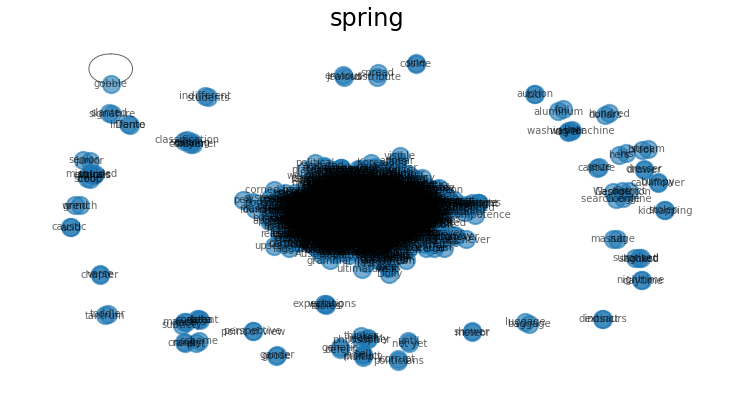

In [252]:
#Visualizando la red

plt.figure(figsize=(10,5))

nx.draw(G1, with_labels=True, font_size=10,alpha=0.6)
plt.title('spring')


Text(0.5, 1.0, 'fruchterman reingold')

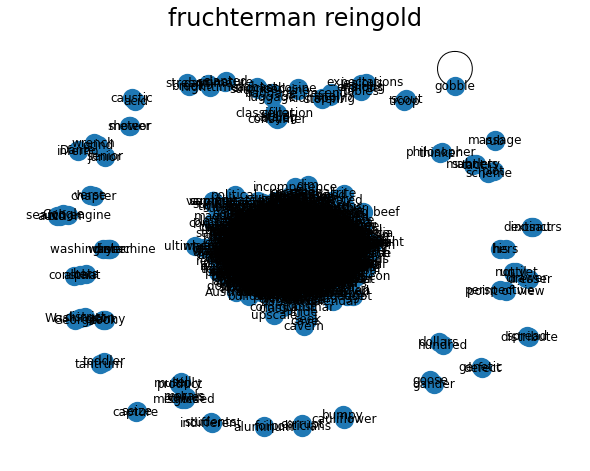

In [254]:
layout=nx.fruchterman_reingold_layout(G1)
nx.draw(G1,layout, with_labels=True)
plt.title('fruchterman reingold')

Histograma de grados:

In [88]:
df_grados_1 = pd.DataFrame(G1.degree,columns=['Node','Degree']).set_index('Node')
df_grados_1.sort_values('Degree',ascending=False).T

Node,money,food,sex,car,love,water,me,green,bad,hard,work,mean,sad,good,man,game,house,paper,book,dog,ball,baby,smart,black,time,fire,woman,white,fruit,red,bird,small,gross,face,hurt,sweet,words,cold,stop,party,...,privileged,construction,continuous,pretense,conversation,connection,prescription,convince,prejudice,cooler,prefer,praise,powers,cornbread,corned beef,prod,program,communist,punctuation,companion,complain,puzzled,putrid,put off,pussy,pursuit,comprehend,concerned,puma,confusing,puke,puck,psychotic,psalm,pry,protest,confident,proof,pronoun,zoo
Degree,46,40,38,35,33,31,30,30,26,24,24,23,23,23,22,22,22,21,20,20,20,20,19,19,19,19,18,18,18,18,18,18,18,17,17,17,17,16,16,16,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


<Figure size 720x288 with 0 Axes>

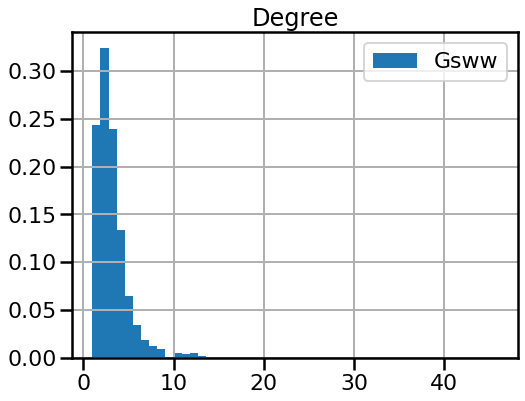

In [97]:
plt.figure(figsize=(10,4))
df_grados_1.hist(bins=50,density=True,label='Gsww')
plt.legend()


Histograma de pesos:

In [61]:
# calculando frecuencia de aparicion de cada cue
df1_0 = data.groupby(['cue']).size().to_frame(name='size').reset_index()
df1_0_sorted = df1_0.sort_values(by=['size'],ascending=False).reset_index()

# calculando frecuencia de aparicion de cada par cue-R1
df2_0 = data.groupby(['cue','R1']).size().to_frame(name='size').reset_index()
df2_0_sorted = df2_0.sort_values(by=['size'],ascending=False).reset_index()

#merge
df_0 = df2_0.merge(df1_0,left_on='cue',right_on='cue')
df_0 = df_0.rename(columns={'size_x':'frec_par','size_y':'frec_cue'})
df_0['frec'] = df_0['frec_par']/df_0['frec_cue']
df_0.head(5)

,cue,R1,frec_par,frec_cue,frec
0,Africa,continent,2,3,0.666667
1,Africa,job,1,3,0.333333
2,Alaska,frontier,1,1,1.000000
3,American,ignorant,1,3,0.333333
4,American,people,1,3,0.333333


Text(0.5, 1.0, 'Histograma aristas Gsww')

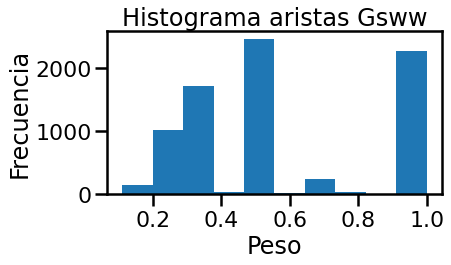

In [87]:
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
plt.hist(df_0.frec,bins=10)
plt.ylabel('Frecuencia')
plt.xlabel('Peso');
plt.title('Histograma aristas Gsww')

El grafo con la funcion edgelist (no entiendo bien la diferencia con el metodo de la matriz de adyacencia):

In [57]:
G1_2 = nx.from_pandas_edgelist(data[['cue','R1']],source='cue',target='R1')

Text(0.5, 1.0, 'spring')

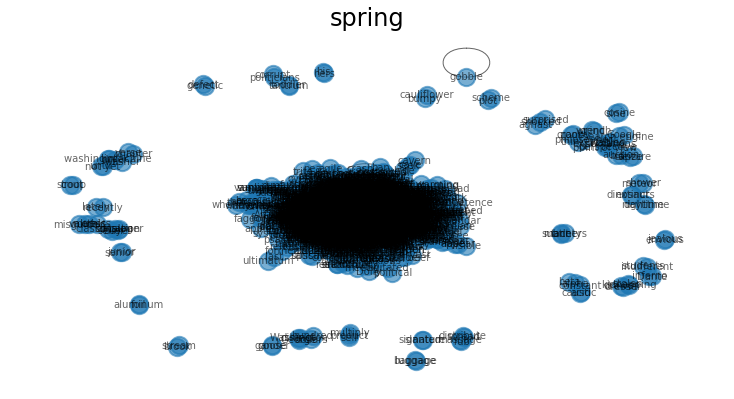

In [58]:
#Visualizando la red

plt.figure(figsize=(10,5))

nx.draw(G1_2, with_labels=True,alpha=0.6,font_size=10)
plt.title('spring')



Text(0.5, 1.0, 'fruchterman reingold')

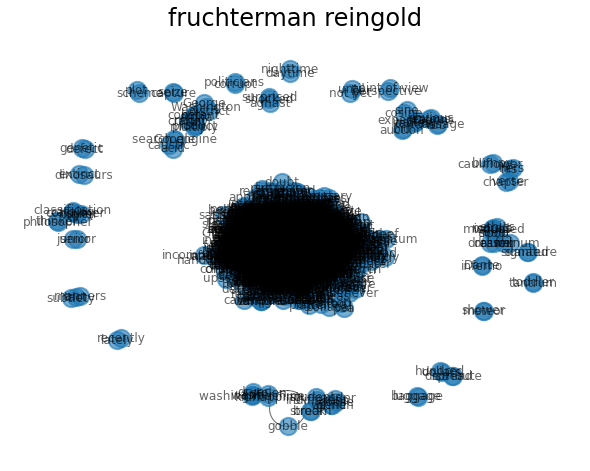

In [59]:
layout=nx.fruchterman_reingold_layout(G1_2)
nx.draw(G1_2,layout, with_labels=True, alpha=0.6)
plt.title('fruchterman reingold')


Calculo numero de aristas que tendria una red con cue + word palabras (con todas las palabras unicas)

In [29]:
df1 = data[['cue']].rename(columns={'cue':'word'},inplace=False) #dejando solo la palabra
df2 = data[['R1']].rename(columns={'R1':'word'},inplace=False)

df_dict = pd.concat([df1,df2])  # concatenando
list_dict = df_dict['word'].unique() #eliminando duplicados
list_dict.shape

(4833,)

In [30]:
print('numero nodos',len(list_dict))
print('numero maximo aristas (no dirigidas y sin loops)',len(list_dict)*(len(list_dict)-1)/2)
print('numero maximo aristas (dirigidas y sin loops)',len(list_dict)*(len(list_dict)-1))
print('numero maximo aristas (dirigidas y con loops)',len(list_dict)*(len(list_dict)))

numero nodos 4833
numero maximo aristas (no dirigidas y sin loops) 11676528.0
numero maximo aristas (dirigidas y sin loops) 23353056
numero maximo aristas (dirigidas y con loops) 23357889


Histograma sobre los pesos (tomados como las frecuencias de las parejas):

Esta fue la red sin sacar las palabras de w2v

# Comparando con las palabras de word2vec

In [31]:
# cargamos word2vec
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

w2v_model2 = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

--2021-12-12 21:17:13--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.97.245
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.97.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz.1’

GoogleNews-vectors- 100%[===================>]   1.53G  73.1MB/s    in 48s     

2021-12-12 21:18:02 (32.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz.1’ saved [1647046227/1647046227]



In [32]:
# sacar palabras que no esten en w2v
l = [w for w in data['cue'] if w not in w2v_model2.vocab]
data_w2v = data[-data['cue'].isin(l)]
print(data_w2v.shape[0]) 

8847


In [33]:
l = [w for w in data_w2v['R1'] if w not in w2v_model2.vocab]
data_w2v = data_w2v[-data_w2v['R1'].isin(l)]
print(data_w2v.shape[0])

8781


In [35]:
# Sacar palabras que no este en cue Y en R1
data_w2v.drop(data_w2v[data_w2v['R1'].isin(data_w2v['cue'].unique())==False].index, inplace=True)
data_w2v.drop(data_w2v[data_w2v['cue'].isin(data_w2v['R1'].unique())==False].index, inplace=True)
data_w2v.shape

(4554, 2)

In [ ]:
#sacando los duplicados
#data_w2v = data_w2v[data_w2v.duplicated()]
#print(data_w2v.shape[0])

647788


#Frecuencia de aparicion de pares

In [ ]:
# calculando frecuencia de aparicion de cada cue
#df1 = data_f.groupby(['cue']).size().to_frame(name='size').reset_index()
#df1_sorted = df1.sort_values(by=['size'],ascending=False).reset_index()
#df1_sorted.head(5)

In [ ]:
# calculando frecuencia de aparicion de cada par cue-R1
#df2 = data_f.groupby(['cue','R1']).size().to_frame(name='size').reset_index()
#df2_sorted = df2.sort_values(by=['size'],ascending=False).reset_index()
#df2_sorted.head(5)

In [ ]:
#df = df2.merge(df1,left_on='cue',right_on='cue')
#df = df.rename(columns={'size_x':'frec_par','size_y':'frec_cue'})
#df['frec'] = df['frec_par']/df['frec_cue']
#df.head(5)

In [ ]:
# Recortando el grafo

#df = df[(df['frec_par'] > 5) & (df['frec_cue'] > 10)]

# Sacar palabras que no estan mas en el cue y la R1
#df.drop(df[df['R1'].isin(df['cue'].unique())==False].index, inplace=True)
#df.drop(df[df['cue'].isin(df['R1'].unique())==False].index, inplace=True)
#print(df.shape[0])

In [36]:
df1_2 = data_w2v[['cue']].rename(columns={'cue':'word'},inplace=False) #dejando solo la palabra
df2_2 = data_w2v[['R1']].rename(columns={'R1':'word'},inplace=False)

df_dict_2 = pd.concat([df1_2,df2_2])  # concatenando
list_dict_2 = df_dict_2['word'].unique() #eliminando duplicados
list_dict_2.shape

(2414,)

In [37]:
print('numero nodos',len(list_dict_2))
print('numero maximo aristas (no dirigidas y sin loops)',len(list_dict_2)*(len(list_dict_2)-1)/2)
print('numero maximo aristas (dirigidas y sin loops)',len(list_dict_2)*(len(list_dict_2)-1))
print('numero maximo aristas (dirigidas y con loops)',len(list_dict_2)*(len(list_dict_2)))

numero nodos 2414
numero maximo aristas (no dirigidas y sin loops) 2912491.0
numero maximo aristas (dirigidas y sin loops) 5824982
numero maximo aristas (dirigidas y con loops) 5827396


#Distancias matrices w2v

Hacemos la matriz de distancias de todas contra todas

In [38]:
distancias_w2v_dict=np.zeros((len(list_dict_2),len(list_dict_2))) #matriz cuadrada
t = time.time()
print('Total de pares de palabras %d'%(len(list_dict_2)*(len(list_dict_2)-1)/2))
for i,ti in enumerate(list_dict_2):
  if i % 1000 ==0:
    print('Palabra %d: %.2f secs'%(i,time.time()-t))
  for j,tj in enumerate(list_dict_2):
    if j>i:
      distancias_w2v_dict[i,j] = abs(1-w2v_model2.similarity(ti,tj))


Total de pares de palabras 2912491
Palabra 0: 0.00 secs
Palabra 1000: 54.80 secs
Palabra 2000: 81.16 secs


In [39]:
distancias_w2v_dict = distancias_w2v_dict + distancias_w2v_dict.T
print(distancias_w2v_dict.shape)

(2414, 2414)


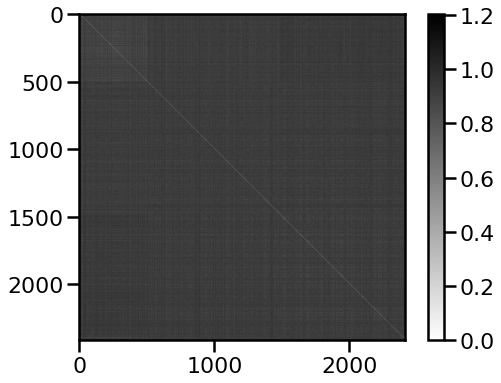

In [40]:
plt.imshow(distancias_w2v_dict,cmap='gray_r')
plt.colorbar()

Son muchos elementos, pero haciendo un zoom, se una comunidad

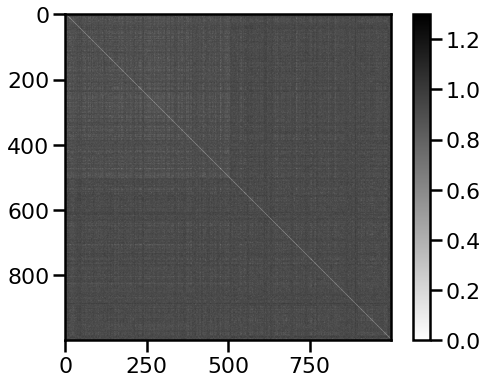

In [41]:
distancia_peque = distancias_w2v_dict[0:1000,0:1000]
plt.imshow(distancia_peque,cmap='gray_r',vmax=1.3,vmin=0)
plt.colorbar()

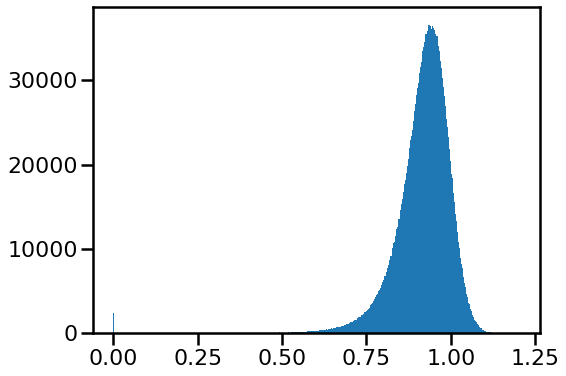

In [43]:
#El histograma de distancias
out = plt.hist(distancias_w2v_dict.flatten(),bins='auto')


La matriz de adyacencia:

In [51]:
df_firstrows_2 = pd.crosstab(data_w2v.cue, data_w2v.R1)
idx = df_firstrows_2.columns.union(df_firstrows_2.index)
matriz_2 = df_firstrows_2.reindex(index = idx, columns=idx, fill_value=0) #armo la matriz de adyacencia

El grafo:

In [66]:
G2= nx.from_pandas_adjacency(matriz_2)

In [67]:
print(nx.info(G2))
print('Is weigthed:',nx.is_weighted(G2))

G2.number_of_nodes(), G1.number_of_edges()

Graph with 2414 nodes and 3563 edges
Is weigthed: True


(2414, 7506)

In [68]:
# Es dirigido
nx.is_directed(G1)

False

Text(0.5, 1.0, 'spring')

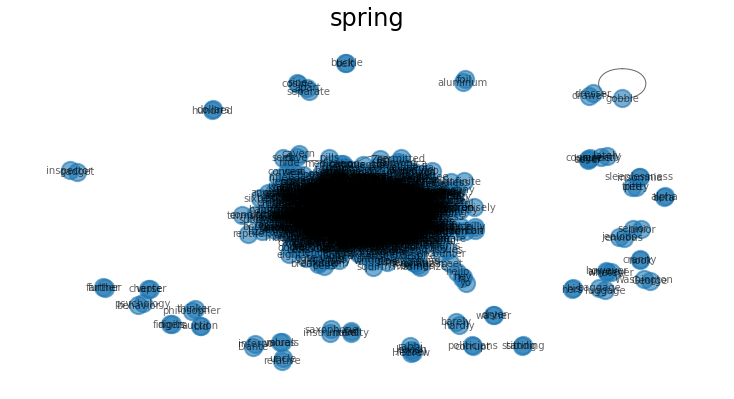

In [56]:
#Visualizando la red

plt.figure(figsize=(10,5))

nx.draw(G2, with_labels=True, font_size=10,alpha=0.6)
plt.title('spring')


In [ ]:
plt.subplot(132)
layout=nx.fruchterman_reingold_layout(G2)
nx.draw(G2,layout, with_labels=True, font_size=10,alpha=0.6)
plt.title('fruchterman reingold')


Aqui ya se ven comunidades

Distribucion de grado

In [77]:
df_grados_2 = pd.DataFrame(G2.degree,columns=['Node','Degree']).set_index('Node')
df_grados_2.sort_values('Degree',ascending=False).T

Node,money,food,sex,green,game,me,good,water,work,love,car,dog,man,hard,time,ball,book,sad,fire,bad,out,smell,fruit,house,small,paper,words,red,death,math,woman,clean,blue,two,stop,color,break,big,face,yellow,...,separate,grumpy,guacamole,guarantee,senior,seller,sleazy,sleeplessness,flora,slither,effect,standing,eight,squirm,squares,enemy,envious,espionage,exclamation,exotic,extremity,eyelash,fad,farms,farther,fearful,feely,socks,socialist,sob,fiddle,fields,snowball,sneaky,finder,fingers,fist,flakes,flies,sponge
Degree,32,23,19,18,18,18,17,17,16,16,15,15,14,14,14,13,13,13,13,13,12,12,12,11,11,11,11,11,10,10,10,10,10,10,9,9,9,9,9,9,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


<Figure size 720x288 with 0 Axes>

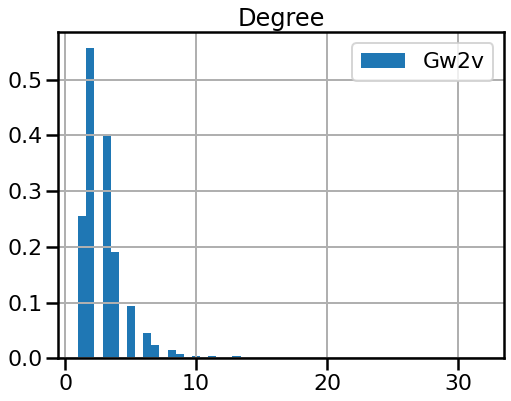

In [98]:
plt.figure(figsize=(10,4))
df_grados_2.hist(bins=50,density=True,label='Gw2v');
plt.legend()


# Caracterizacion de los grafos

Red Gsww (G1)

Es pesada la red?

In [99]:
print(nx.info(G1))
print('Is weigthed:',nx.is_weighted(G1))

G1.number_of_nodes(), G1.number_of_edges()

Graph with 4833 nodes and 7506 edges
Is weigthed: True


(4833, 7506)

Red Gw2v

In [100]:
print(nx.info(G2))
print('Is weigthed:',nx.is_weighted(G2))

G2.number_of_nodes(), G2.number_of_edges()

Graph with 2414 nodes and 3563 edges
Is weigthed: True


(2414, 3563)

¿Las redes tienen loops o aristas múltiples? ¿Son redes completamente conectadas?

In [101]:
# Tienen multiples aristas (y self-loops)
G1.is_multigraph(), G2.is_multigraph()

(False, False)

In [102]:
# Están conectados?
nx.is_connected(G1), nx.is_connected(G2)

(False, False)

Diametro de la red. Ahora dieron no conectadas, no se calcula...

In [ ]:
#nx.diameter(G1)

G1 es una red cohesiva, tiene diametro pequeño y está conectada

Densidad de la red:

In [103]:
nx.density(G1), nx.density(G2)

(0.0006428280735506308, 0.0012233514197983787)

Son redes muy "esparsas". La primera es menos densa aun

Clustering global

In [104]:
nx.average_clustering(G1), nx.average_clustering(G2)

(0.03496651894491525, 0.04576765594410794)

Los elementos en ambas redes tienden a conectarse muy poco entre si

Asortividad (selectividad)

In [105]:
nx.degree_assortativity_coefficient(G1), nx.degree_assortativity_coefficient(G2)

(-0.08888566496640728, -0.01927061590585394)

las redes son disasortativas, los nodos conectados difieren mucho en sus grados

# Distribucion

In [79]:
results = powerlaw.Fit(df_grados_2['Degree'],discrete=True,)
R,p = results.distribution_compare('power_law', 'exponential')

Calculating best minimal value for power law fit


In [80]:
# si el primer numero es grande, la distribucion mas probable es la primera candidata
print(R,p)

16.700079963213025 0.013870094763478709


In [85]:
# Exponente de la power law y desviacion estandar
results.power_law.alpha, results.power_law.sigma

(3.8764692806626124, 0.1623285525998376)

Text(0.5, 0, 'grado')

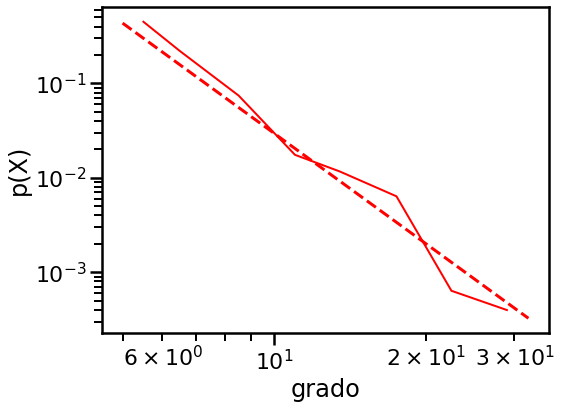

In [81]:
figPDF = results.plot_pdf(color='r', linewidth=2)
results.power_law.plot_pdf(color='r', linestyle='--', ax=figPDF)

####
figPDF.set_ylabel(u"p(X)")
figPDF.set_xlabel(r"grado")

Podria ajustarle bien una ley de potencias

Las distribuciones de grado comparadas:

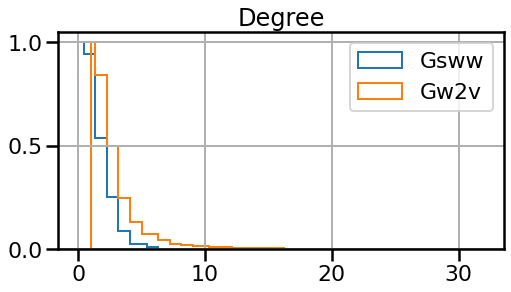

In [106]:
plt.figure(figsize=(8,4));
(np.sum(matriz,axis=1)).hist(density=True,histtype='step',label='Gsww', cumulative=-1,bins=20 );
df_grados_2.hist(density=True,ax=plt.gca(), histtype='step',label='Gw2v', cumulative=-1, bins=100);
plt.legend();

In [ ]:
#demora
#omega = nx.algorithms.smallworld.omega(G1, niter=60, nrand=4)

# Medidas de centralidad

Centralidad de grado

In [86]:
 pos_1 = nx.spring_layout(G1,k=0.2)
 pos_2 = nx.spring_layout(G2,k=0.2)

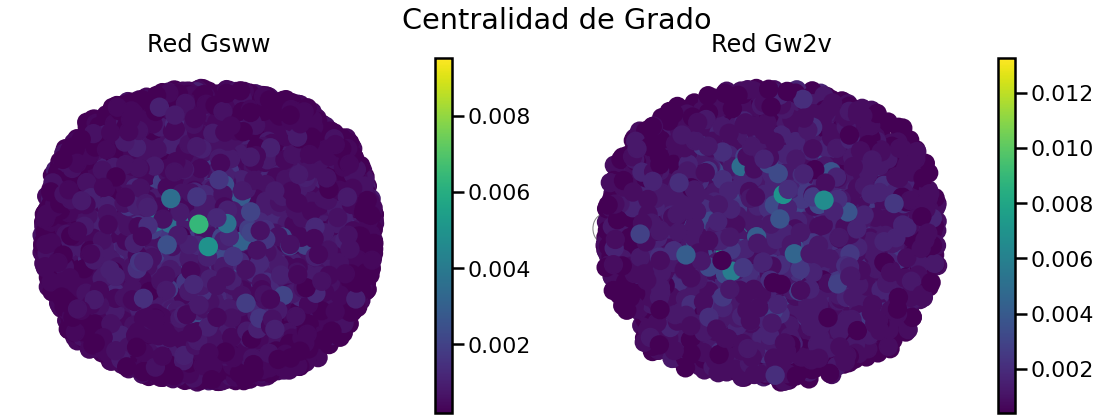

In [109]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

centrality = nx.degree_centrality(G1)
values = [v for n,v in centrality.items()]
nx.draw(G1,pos=pos_1, with_labels=False,node_color = values, font_color='white', edge_color='gray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red Gsww');

centrality = nx.degree_centrality(G2)
values = [v for n,v in centrality.items()]
nx.draw(G2,pos=pos_2, with_labels=False,node_color = values, font_color='white', edge_color='gray',ax=axs[1])
axs[1].set_title('Red Gw2v');
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])

plt.suptitle('Centralidad de Grado',y=1.0)
plt.tight_layout();

Como sale muy fea esta visualizacion, grafico el histograma de centralidades

In [110]:
degCent1 = nx.degree_centrality(G1)
degCent2 = nx.degree_centrality(G2)
print(min(degCent1.values()),max(degCent1.values()))
print(min(degCent2.values()),max(degCent2.values()))

0.00020695364238410596 0.009519867549668874
0.0004144218814753419 0.01326150020721094


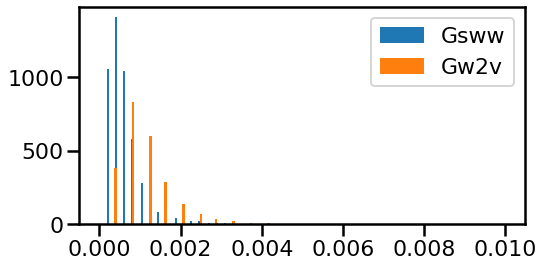

In [111]:

plt.figure(figsize=(8,4));
out1 = plt.hist(degCent1.values(),bins='auto',range=[0,0.01],label = 'Gsww')
out2 = plt.hist(degCent2.values(),bins='auto',range=[0,0.01],label = 'Gw2v')
plt.legend()

Ambas redes tienen nodos con centralidades pequeñas. La Gv2v tiene nodos con centralidad mas ¨grande¨ que la Gsww

Las otras tres centralidades demoran, no correr.

Centralidad de betweeness

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

centrality = nx.betweenness_centrality(G1)
values = [v for n,v in centrality.items()]
nx.draw(G1,pos=pos_1, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red Gsww');

centrality = nx.betweenness_centrality(G2)
values = [v for n,v in centrality.items()]
nx.draw(G2,pos=pos_2, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[1])
axs[1].set_title('Red Gw2v');
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])
plt.suptitle('Centralidad de Betweenness',y=1.0);
plt.tight_layout();

  Centralidad de cercania

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

centrality = nx.closeness_centrality(G1)
values = [v for n,v in centrality.items()]
nx.draw(G1,pos=pos_1, with_labels=False,node_color = values, font_color='white', edge_color='gray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red Gsww');

centrality = nx.closeness_centrality(G2)
values = [v for n,v in centrality.items()]
nx.draw(G2,pos=pos_1, with_labels=False,node_color = values, font_color='white', edge_color='gray',ax=axs[1])
axs[1].set_title('Red Gw2v');
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])
plt.suptitle('Centralidad de Cercanía',y=1.0);
plt.tight_layout();

Centralidad de autovector

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

centrality = nx.eigenvector_centrality(G1)
values = [v for n,v in centrality.items()]
nx.draw(G1,pos=pos_1, with_labels=False, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red observada');

centrality = nx.eigenvector_centrality(G_2)
values = [v for n,v in centrality.items()]
nx.draw(G2,pos=pos_2, with_labels=False, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[1])
axs[1].set_title('Red percibida');
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])
plt.suptitle('Centralidad de Autovector',y=1.0);
plt.tight_layout();

# Deteccion de comunidades

In [112]:
from networkx.algorithms.community import modularity
import community.community_louvain as community_louvain

Deteccion con algoritmo de Louvain

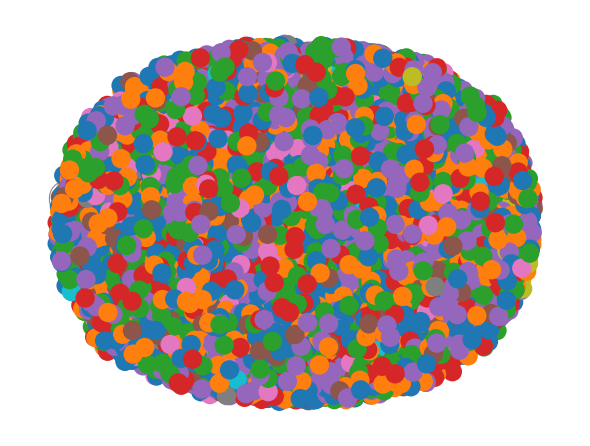

In [113]:
modulos = community_louvain.best_partition(G1)
values_1 = [v for n,v in modulos.items()]
nx.draw(G1,pos=pos_1, with_labels=False,cmap=plt.cm.tab10,node_color = values_1, edge_color='gray')

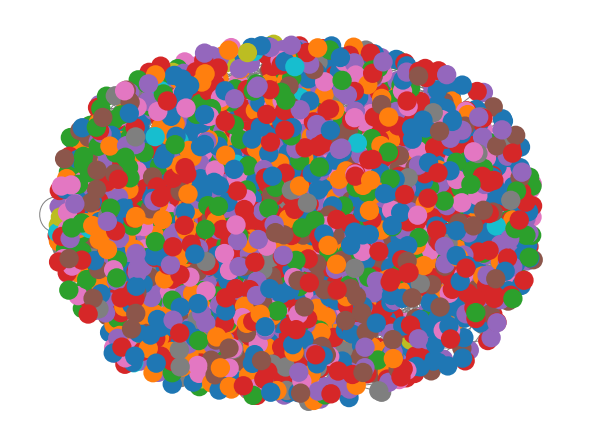

In [114]:
modulos = community_louvain.best_partition(G2)
values_2 = [v for n,v in modulos.items()]
nx.draw(G2,pos=pos_2, with_labels=False,cmap=plt.cm.tab10,node_color = values_2, edge_color='gray')

# Comparacion con redes small world

In [115]:
repetitions = 1
dat = []
for i in range(repetitions):
    d = {}
    G_pl = nx.barabasi_albert_graph(G1.number_of_nodes(),10,seed=i)
    d['ba_avg_clus'] = nx.average_clustering(G_pl)
    d['ba_avg_path'] = nx.average_shortest_path_length(G_pl)
    d['ba_avg_degree'] = G_pl.number_of_edges()/G_pl.number_of_nodes()
    d['ba_alpha'] = powerlaw.Fit([d for n, d in G_pl.degree],discrete=True,xmin=8).alpha

    G_r = nx.gnm_random_graph(G1.number_of_nodes(),G1.number_of_edges(),seed=i)    
    d['er_avg_clus'] = nx.average_clustering(G_r)
    d['er_avg_path'] = nx.average_shortest_path_length(G_r)
    
    G_sw = nx.newman_watts_strogatz_graph(G1.number_of_nodes(),round(G1.number_of_edges()/G1.number_of_nodes()),0.03,seed=i)
    d['ws_avg_clus'] = nx.average_clustering(G_sw)
    d['ws_avg_path'] = nx.average_shortest_path_length(G_sw)
    dat.append(d)

df_s = pd.DataFrame(dat)
axs = df_s.filter(regex='avg_clus').hist(figsize=(12,8),density=True)
for ax in axs.flatten():
    ax.vlines(nx.average_clustering(G1),0,20,lw=3,color='r')

axs = df_s.filter(regex='avg_path').hist(figsize=(12,8),density=True)
for ax in axs.flatten():
    ax.vlines(nx.average_shortest_path_length(G1),0,20,lw=3,color='r')

NetworkXError: ignored